In [ ]:
# Put this as the very first TF-related cell and restart runtime before running any TF imports
import tensorflow as tf

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("Memory growth enabled on GPU(s).")
    except RuntimeError as e:
        print("Could not set memory growth (RuntimeError):", e)
else:
    print("No GPUs found for memory growth enabling.")


Memory growth enabled on GPU(s).


In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')   # follow the link, paste auth code

# # path on Drive where you uploaded the zip, e.g. My Drive
# zip_path = '/content/drive/MyDrive/M.Tech/cell_images.zip'
# !unzip -q "$zip_path" -d /content/cell_images
# # -q for quiet; remove -q to see files

# # quick verify
# import os
# def count_images(root):
#     total=0
#     for root_, dirs, files in os.walk(root):
#         for f in files:
#             if f.lower().endswith(('.png','.jpg','.jpeg')):
#                 total+=1
#     return total

# print("Total images:", count_images('/content/cell_images'))
# print("Classes:", os.listdir('/content/cell_images'))


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Total images: 27558
Classes: ['cell_images']


# Transfer Learning (VGG16) — Malaria Cell Images
Notebook: train VGG16 on Malaria Cell Images (Colab GPU)
- Mount Google Drive, create train/val/test splits
- Train transfer-learning model (VGG16)
- Optional fine-tune
- Save model (H5 + SavedModel) and training artifacts to Google Drive
- Provide download & MLflow logging helpers

In [ ]:
#Cell 1
from google.colab import drive
drive.mount('/content/drive')

# Set your project folder on Drive (change if you prefer another folder)
DRIVE_PATH = '/content/drive/MyDrive/M.Tech/malaria_project'
import os
os.makedirs(DRIVE_PATH, exist_ok=True)
print("Drive project path set to:", DRIVE_PATH)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Drive project path set to: /content/drive/MyDrive/M.Tech/malaria_project


In [ ]:
#Cell-2
# Only run this if you uploaded a zip to Drive and haven't unzipped yet.
# Change ZIP_PATH if your zip is elsewhere in Drive.
ZIP_PATH = '/content/drive/MyDrive/M.Tech/cell_images.zip'  # <- update if different

if os.path.exists(ZIP_PATH):
    print("Found zip at:", ZIP_PATH)
    !unzip -q "$ZIP_PATH" -d /content/cell_images
    print("Unzipped to /content/cell_images")
else:
    print("Zip not found at", ZIP_PATH)
    print("If dataset already exists in /content/cell_images, skip unzip.")


Found zip at: /content/drive/MyDrive/M.Tech/cell_images.zip
replace /content/cell_images/cell_images/Parasitized/C100P61ThinF_IMG_20150918_144104_cell_162.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
Unzipped to /content/cell_images


In [ ]:
#Cell -3
import os

SRC = '/content/cell_images'  # where images should be
def count_images(root):
    total=0
    for _root, dirs, files in os.walk(root):
        for f in files:
            if f.lower().endswith(('.png','.jpg','.jpeg')):
                total+=1
    return total

if os.path.exists(SRC):
    print("Dataset root:", SRC)
    print("Total images:", count_images(SRC))
    classes = [d for d in os.listdir(SRC) if os.path.isdir(os.path.join(SRC, d))]
    print("Classes:", classes)
    for c in classes:
        p = os.path.join(SRC, c)
        print(f"  {c}: {len([f for f in os.listdir(p) if f.lower().endswith(('.png','.jpg','.jpeg'))])}")
else:
    print("Dataset not found at", SRC)


Dataset root: /content/cell_images
Total images: 27558
Classes: ['cell_images']
  cell_images: 0


In [ ]:
#Cell -4
# Confirm GPU availability in Colab
import tensorflow as tf
print("TensorFlow version:", tf.__version__)
gpus = tf.config.list_physical_devices('GPU')
print("GPUs detected:", gpus)
!nvidia-smi


TensorFlow version: 2.19.0
GPUs detected: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Mon Nov 24 18:05:02 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   43C    P8              9W /   70W |       2MiB /  15360MiB |      0%      Default |
|                              

In [ ]:

# Cell 6 replacement — use Colab's preinstalled TensorFlow
import tensorflow as tf
print("Using TensorFlow version:", tf.__version__)
# proceed — this TF is GPU-enabled in Colab



Using TensorFlow version: 2.19.0


In [ ]:
#cell -7
# This copies images into /content/data_split/{train,val,test}/{class}/
# It keeps the original in /content/cell_images (Drive source)
import os, random, shutil
from pathlib import Path

SRC = '/content/cell_images/cell_images'   # source dataset (classes as subfolders)
TARGET = '/content/data_split' # will be created for faster local IO
train_pct, val_pct, test_pct = 0.8, 0.1, 0.1
random.seed(42)

if not os.path.exists(SRC):
    raise SystemExit(f"Source not found: {SRC}")

# remove TARGET if exists? we will create fresh
if os.path.exists(TARGET):
    print("Target already exists, removing and recreating (be careful)...")
    shutil.rmtree(TARGET)
os.makedirs(TARGET, exist_ok=True)

classes = sorted([d for d in os.listdir(SRC) if os.path.isdir(os.path.join(SRC, d))])
print("Classes:", classes)

for cls in classes:
    src_cls = os.path.join(SRC, cls)
    files = [f for f in os.listdir(src_cls) if f.lower().endswith(('.png','.jpg','.jpeg'))]
    random.shuffle(files)
    n = len(files)
    n_train = int(n * train_pct)
    n_val = int(n * val_pct)
    train_files = files[:n_train]
    val_files = files[n_train:n_train+n_val]
    test_files = files[n_train+n_val:]
    for split_name, split_files in [('train', train_files), ('val', val_files), ('test', test_files)]:
        out_dir = os.path.join(TARGET, split_name, cls)
        os.makedirs(out_dir, exist_ok=True)
        for fname in split_files:
            shutil.copy2(os.path.join(src_cls, fname), os.path.join(out_dir, fname))

print("Done creating splits at:", TARGET)
print("Counts -> train, val, test:")
for s in ['train','val','test']:
    print(s, sum(len(files) for _,_,files in os.walk(os.path.join(TARGET,s))))

Target already exists, removing and recreating (be careful)...
Classes: ['Parasitized', 'Uninfected']
Done creating splits at: /content/data_split
Counts -> train, val, test:
train 22046
val 2754
test 2758


In [ ]:
#cell -8
def count_per_split(root):
    out = {}
    for split in ['train','val','test']:
        path = os.path.join(root, split)
        out[split] = sum(1 for _root,_dirs,files in os.walk(path) for f in files if f.lower().endswith(('.png','.jpg','.jpeg')))
    return out

print("Split counts:", count_per_split('/content/data_split'))


Split counts: {'train': 22046, 'val': 2754, 'test': 2758}


In [ ]:
#cell -9
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMG_SIZE = (224,224)
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=20,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   zoom_range=0.1,
                                   horizontal_flip=True)
val_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory('/content/data_split/train', target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='binary')
val_gen = val_datagen.flow_from_directory('/content/data_split/val', target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='binary')


Found 22046 images belonging to 2 classes.
Found 2754 images belonging to 2 classes.


In [ ]:
#cell -10
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

def build_vgg16_model(input_shape=(*IMG_SIZE,3), dropout=0.5, lr=1e-4):
    base = VGG16(include_top=False, weights='imagenet', input_shape=input_shape)
    base.trainable = False   # freeze base for stage 1
    x = GlobalAveragePooling2D()(base.output)
    x = Dropout(dropout)(x)
    out = Dense(1, activation='sigmoid')(x)
    model = Model(inputs=base.input, outputs=out)
    model.compile(optimizer=Adam(learning_rate=lr), loss='binary_crossentropy', metrics=['accuracy'])
    return model, base

model, base_model = build_vgg16_model()
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,715,201 (56.13 MB)

 Trainable params: 513 (2.00 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [ ]:
#cell -11
import json
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

EPOCHS = 8
OUT_DIR = os.path.join(DRIVE_PATH, 'colab_artifacts')
os.makedirs(OUT_DIR, exist_ok=True)
CKPT_H5 = os.path.join(OUT_DIR, 'best_model_stage1.h5')

callbacks = [
    EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
    ModelCheckpoint(CKPT_H5, monitor='val_loss', save_best_only=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2)
]

history = model.fit(train_gen, validation_data=val_gen, epochs=EPOCHS, callbacks=callbacks)
# Save history to Drive
hist_path = os.path.join(OUT_DIR, 'history_stage1.json')
with open(hist_path, 'w') as f:
    json.dump(history.history, f)
print("Stage1 done. Artifacts ->", OUT_DIR)


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/8
689/689 ━━━━━━━━━━━━━━━━━━━━ 0s 433ms/step - accuracy: 0.5111 - loss: 0.7421

689/689 ━━━━━━━━━━━━━━━━━━━━ 331s 459ms/step - accuracy: 0.5112 - loss: 0.7421 - val_accuracy: 0.7694 - val_loss: 0.6757 - learning_rate: 1.0000e-04
Epoch 2/8
689/689 ━━━━━━━━━━━━━━━━━━━━ 0s 414ms/step - accuracy: 0.5466 - loss: 0.6872

689/689 ━━━━━━━━━━━━━━━━━━━━ 301s 437ms/step - accuracy: 0.5466 - loss: 0.6872 - val_accuracy: 0.7974 - val_loss: 0.6590 - learning_rate: 1.0000e-04
Epoch 3/8
689/689 ━━━━━━━━━━━━━━━━━━━━ 0s 414ms/step - accuracy: 0.6012 - loss: 0.6651

689/689 ━━━━━━━━━━━━━━━━━━━━ 302s 438ms/step - accuracy: 0.6012 - loss: 0.6651 - val_accuracy: 0.7705 - val_loss: 0.6442 - learning_rate: 1.0000e-04
Epoch 4/8
689/689 ━━━━━━━━━━━━━━━━━━━━ 0s 415ms/step - accuracy: 0.6459 - loss: 0.6462

689/689 ━━━━━━━━━━━━━━━━━━━━ 303s 439ms/step - accuracy: 0.6459 - loss: 0.6462 - val_accuracy: 0.7985 - val_loss: 0.6306 - learning_rate: 1.0000e-04
Epoch 5/8
689/689 ━━━━━━━━━━━━━━━━━━━━ 0s 415ms/step - accuracy: 0.6697 - loss: 0.6344

689/689 ━━━━━━━━━━━━━━━━━━━━ 302s 438ms/step - accuracy: 0.6697 - loss: 0.6344 - val_accuracy: 0.7785 - val_loss: 0.6191 - learning_rate: 1.0000e-04
Epoch 6/8
689/689 ━━━━━━━━━━━━━━━━━━━━ 0s 418ms/step - accuracy: 0.6881 - loss: 0.6235

689/689 ━━━━━━━━━━━━━━━━━━━━ 304s 441ms/step - accuracy: 0.6881 - loss: 0.6235 - val_accuracy: 0.7963 - val_loss: 0.6076 - learning_rate: 1.0000e-04
Epoch 7/8
689/689 ━━━━━━━━━━━━━━━━━━━━ 0s 420ms/step - accuracy: 0.7037 - loss: 0.6100

689/689 ━━━━━━━━━━━━━━━━━━━━ 305s 443ms/step - accuracy: 0.7037 - loss: 0.6100 - val_accuracy: 0.7858 - val_loss: 0.5982 - learning_rate: 1.0000e-04
Epoch 8/8
689/689 ━━━━━━━━━━━━━━━━━━━━ 0s 416ms/step - accuracy: 0.7195 - loss: 0.5989

689/689 ━━━━━━━━━━━━━━━━━━━━ 303s 440ms/step - accuracy: 0.7195 - loss: 0.5989 - val_accuracy: 0.7996 - val_loss: 0.5886 - learning_rate: 1.0000e-04
Stage1 done. Artifacts -> /content/drive/MyDrive/M.Tech/malaria_project/colab_artifacts


In [ ]:
#Cell -12
# Fine-tune: unfreeze last N conv blocks of VGG16 (careful — small lr)
# We'll unfreeze last 6 layers (you can tune this)
for layer in base_model.layers[-6:]:
    layer.trainable = True

model.compile(optimizer=Adam(learning_rate=1e-5), loss='binary_crossentropy', metrics=['accuracy'])
FINETUNE_EPOCHS = 4
CKPT_H5_FT = os.path.join(OUT_DIR, 'best_model_finetune.h5')
callbacks_ft = [
    EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
    ModelCheckpoint(CKPT_H5_FT, monitor='val_loss', save_best_only=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2)
]

history_ft = model.fit(train_gen, validation_data=val_gen, epochs=FINETUNE_EPOCHS, callbacks=callbacks_ft)
with open(os.path.join(OUT_DIR, 'history_finetune.json'), 'w') as f:
    json.dump(history_ft.history, f)

final_h5 = os.path.join(OUT_DIR, 'malaria_vgg16_final.h5')
model.save(final_h5)
print("Fine-tune done. Final H5 saved to:", final_h5)


Epoch 1/4
689/689 ━━━━━━━━━━━━━━━━━━━━ 0s 451ms/step - accuracy: 0.8908 - loss: 0.2847

689/689 ━━━━━━━━━━━━━━━━━━━━ 337s 474ms/step - accuracy: 0.8909 - loss: 0.2846 - val_accuracy: 0.9492 - val_loss: 0.1505 - learning_rate: 1.0000e-05
Epoch 2/4
689/689 ━━━━━━━━━━━━━━━━━━━━ 0s 437ms/step - accuracy: 0.9475 - loss: 0.1555

689/689 ━━━━━━━━━━━━━━━━━━━━ 321s 465ms/step - accuracy: 0.9475 - loss: 0.1555 - val_accuracy: 0.9492 - val_loss: 0.1348 - learning_rate: 1.0000e-05
Epoch 3/4
689/689 ━━━━━━━━━━━━━━━━━━━━ 0s 440ms/step - accuracy: 0.9492 - loss: 0.1478

689/689 ━━━━━━━━━━━━━━━━━━━━ 324s 470ms/step - accuracy: 0.9492 - loss: 0.1478 - val_accuracy: 0.9564 - val_loss: 0.1254 - learning_rate: 1.0000e-05
Epoch 4/4
689/689 ━━━━━━━━━━━━━━━━━━━━ 0s 439ms/step - accuracy: 0.9521 - loss: 0.1400

689/689 ━━━━━━━━━━━━━━━━━━━━ 319s 463ms/step - accuracy: 0.9521 - loss: 0.1400 - val_accuracy: 0.9586 - val_loss: 0.1226 - learning_rate: 1.0000e-05


Fine-tune done. Final H5 saved to: /content/drive/MyDrive/M.Tech/malaria_project/colab_artifacts/malaria_vgg16_final.h5


In [ ]:
#cell -13
savedmodel_dir = os.path.join(OUT_DIR, 'saved_model')
model.export(savedmodel_dir)
print("SavedModel saved to:", savedmodel_dir)

# Zip the SavedModel folder for easier download
zip_out = os.path.join(OUT_DIR, 'saved_model.zip')
!zip -r -q "$zip_out" "$savedmodel_dir"
print("Zipped SavedModel to:", zip_out)


Saved artifact at '/content/drive/MyDrive/M.Tech/malaria_project/colab_artifacts/saved_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor_22')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  133242251688464: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133242251689616: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133242251689424: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133242251686736: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133242311224848: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133242251689808: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133242251688848: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133242251689040: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133242251689232: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133242251686544: TensorS

In [ ]:
#cell -14
from tensorflow.keras.preprocessing.image import ImageDataGenerator
test_datagen = ImageDataGenerator(rescale=1./255)
test_gen = test_datagen.flow_from_directory('/content/data_split/test', target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='binary', shuffle=False)

eval_res = model.evaluate(test_gen)
print("Test results (loss, accuracy):", eval_res)

metrics = {'test_loss': float(eval_res[0]), 'test_accuracy': float(eval_res[1])}
import json
with open(os.path.join(OUT_DIR, 'test_metrics.json'), 'w') as f:
    json.dump(metrics, f)
print("Saved test metrics to Drive.")


Found 2758 images belonging to 2 classes.


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


87/87 ━━━━━━━━━━━━━━━━━━━━ 18s 205ms/step - accuracy: 0.9303 - loss: 0.1516
Test results (loss, accuracy): [0.1396249383687973, 0.9503263235092163]
Saved test metrics to Drive.


87/87 ━━━━━━━━━━━━━━━━━━━━ 17s 177ms/step
Confusion Matrix:
 [[1272  107]
 [  30 1349]]
Classification Report:
               precision    recall  f1-score   support

 Parasitized       0.98      0.92      0.95      1379
  Uninfected       0.93      0.98      0.95      1379

    accuracy                           0.95      2758
   macro avg       0.95      0.95      0.95      2758
weighted avg       0.95      0.95      0.95      2758



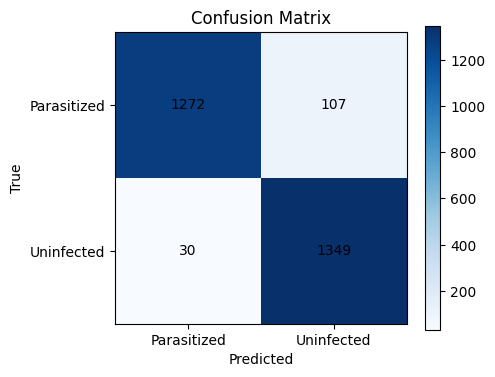

Confusion matrix saved to: /content/drive/MyDrive/M.Tech/malaria_project/colab_artifacts/confusion_matrix.png


In [ ]:
#cell -15
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt

# predict on test set (probabilities)
preds = model.predict(test_gen)
y_pred = (preds.flatten() > 0.5).astype(int)
y_true = test_gen.classes

cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:\n", cm)
print("Classification Report:\n", classification_report(y_true, y_pred, target_names=test_gen.class_indices.keys()))

# plot
plt.figure(figsize=(5,4))
plt.imshow(cm, cmap='Blues')
plt.title('Confusion Matrix')
plt.colorbar()
plt.xlabel('Predicted')
plt.ylabel('True')
plt.xticks([0,1], list(test_gen.class_indices.keys()))
plt.yticks([0,1], list(test_gen.class_indices.keys()))
for (i, j), z in np.ndenumerate(cm):
    plt.text(j, i, str(z), ha='center', va='center')
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, 'confusion_matrix.png'))
plt.show()
print("Confusion matrix saved to:", os.path.join(OUT_DIR, 'confusion_matrix.png'))


In [ ]:
#cell -16
# Browser download (may time out for very large files)
from google.colab import files
files.download(os.path.join(OUT_DIR, 'malaria_vgg16_final.h5'))  # H5
# or download zipped saved model:
# files.download(os.path.join(OUT_DIR, 'saved_model.zip'))


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
#cell -17 is for link if download not successful and cell -18 is for mlflow tracking optional
#cell -19 is for saving meta data to drive
import json, platform
meta = {
    "tf_version": tf.__version__,
    "train_split_counts": count_per_split('/content/data_split'),
    "epochs_stage1": EPOCHS,
    "finetune_epochs": FINETUNE_EPOCHS,
    "batch_size": BATCH_SIZE,
    "img_size": IMG_SIZE,
    "notes": "Model trained in Colab GPU. Save H5 and SavedModel to Drive and download to local machine."
}
with open(os.path.join(OUT_DIR, 'metadata.json'), 'w') as f:
    json.dump(meta, f, indent=2)
print("Saved metadata.json to:", os.path.join(OUT_DIR, 'metadata.json'))


Saved metadata.json to: /content/drive/MyDrive/M.Tech/malaria_project/colab_artifacts/metadata.json


## Next steps (after downloading model)
- Move `malaria_vgg16_final.h5` (or zipped SavedModel) into your local repo `malaria-vgg16/models/`.
- In VS Code:
  - Run `mlflow ui` (if you want local MLflow) and run the `scripts/register_model_mlflow.py` to register model.
  - Build your FastAPI app that loads `models/malaria_vgg16_final.h5` for inference.
  - Create Prefect flows that run preprocessing and evaluation (training step can be a placeholder or call to saved model).
  - Containerize with Docker and test inference endpoints locally.
- If you logged MLflow runs to Drive (`mlruns_colab`), either copy the folder to your repo or re-register the model locally using the saved H5.
